In [1]:
# KOSPI200과 LIBOR1m를 이용한 Risk-Parity 전략
# Monthly rebalancing 가정
# 측정기간(tau), 투자 시작일(stDateNum)을 바꿔가며 Back-test 가능

# 현재 디렉토리 확인
import os
os.getcwd()

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# ============================================================================
# Data 로딩 및 변수 정의
# ============================================================================
# 날짜 기준으로 오름차순 정렬된 Data 불러오기
data_excel = pd.ExcelFile('./Data/data_K200.xlsx') # read_excel과 차이= 엑셀 시트 여러개를 한번에 가져옴
data_df = data_excel.parse(sheet_name = 'data_m', header=1) # d / w(Fri) / m(EoM)
rawTime = data_df.iloc[:, 0].copy()     # Date
rawRisky = data_df.iloc[:, 1].copy()    # Risky asset price (K200)
rawExchange = data_df.iloc[:, 5].copy() # Exchange rate(KRW/USD)
rawRf = data_df.iloc[:, 6].copy()       # Risk-free rate (LIBOR1m, %)
numRaw = len(rawTime)

# Individual HP C/G (%)
rawCR1 = rawRisky.pct_change()*100 # (rawRisky / rawRisky.shift(1) - 1) * 100
rawCR2 = rawExchange.pct_change()*100  # (rawExchange / rawExchange.shift(1) - 1) * 100

# 무위험이자율 수익률 계산
rawLibor = (rawRf.shift(1)/12) # LIBOR1m의 정의를 고려하여 1칸 shift + 연율화 scaling
rawExLibor = ((1+rawLibor/100)*(1+rawCR2/100)-1)*100  # USD 이자를 KRW 이자로 환전하는 효과를 반영하여 KRW 수익률 계산

# Individual HPR (%, TR)
rawR1 = rawCR1.copy()
rawR2 = rawCR2 + rawExLibor

In [3]:
# ============================================================================
# Back Test 시작시점 기준으로 데이터 정리 (이 작업을 원하지 않으면 엑셀을 편집)
# ============================================================================
stDateNum = 19941228  # 19941228  # Back Test 시작일 (투자 시작일)
stDate = pd.to_datetime(str(stDateNum), format='%Y%m%d')
idx = np.argmin(np.abs(rawTime - stDate))  # Back Test 시작일에 해당하는 index

Time = rawTime[idx:].copy().reset_index(drop = True)  # 깊은 복사, index 초기화
R1 = rawR1[idx:].copy().reset_index(drop = True)
R2 = rawR2[idx:].copy().reset_index(drop = True)
numData = Time.shape[0]  # len(Data) or len(Data.index)

In [4]:
# ============================================================================
# 변동성 계산
# ============================================================================

RiskHorizon = 12

Sig1 = rawR1[idx-RiskHorizon+1:].rolling(window=RiskHorizon).std().dropna().reset_index(drop = True)
Sig2 = rawR2[idx-RiskHorizon+1:].rolling(window=RiskHorizon).std().dropna().reset_index(drop = True)

# Weight
W1 = Sig2/(Sig1+Sig2)
W2 = Sig1/(Sig1+Sig2)

In [5]:
# ============================================================================
# 포트폴리오의 Value, DD 계산
# ============================================================================

# Portfolio Value
Rp = pd.Series(np.zeros(numData)) # 수익률 (단위: %)
Vp = pd.Series(np.zeros(numData)) # Value
Vp[0] = 100 # 투자원금 = 100
for t in range(1, numData) : 
    Rp[t] = W1[t-1]*R1[t] + W2[t-1]*R2[t]   # HPR
    Vp[t] = Vp[t-1]*(1 + Rp[t]/100)         # Value
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [6]:
# ============================================================================
# 벤치마크의 Value, DD 계산
# ============================================================================

# KOSPI200 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb1 = pd.Series(np.zeros(numData)) # Value
Vb1[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb1[t] = Vb1[t-1]*(1 + R1[t]/100)   

MAXb1 = Vb1.cummax()
DDb1 = (Vb1 / MAXb1 - 1) * 100  # 단위: %

# USD/KRW 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb2 = pd.Series(np.zeros(numData)) # Value
Vb2[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb2[t] = Vb2[t-1]*(1 + R2[t]/100)      

MAXb2 = Vb2.cummax()
DDb2 = (Vb2 / MAXb2 - 1) * 100  # 단위: %

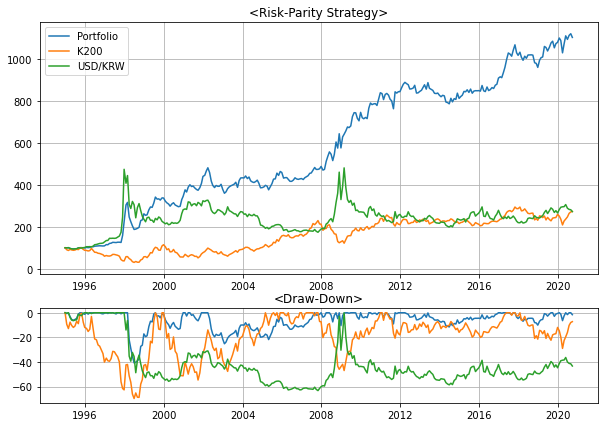

In [7]:
# ============================================================================
# 그래프 그리기
# ============================================================================

# Value와 MDD 그리기
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp, label = 'Portfolio')
ax0.plot(Time, Vb1, label = 'K200')
ax0.plot(Time, Vb2, label = 'USD/KRW')
ax0.set_title('<Risk-Parity Strategy>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp, label = 'Fixed')
ax1.plot(Time, DDb1, label = 'K200')
ax1.plot(Time, DDb2, label = 'USD/KRW')
ax1.set_title('<Draw-Down>')
ax1.grid(True)

plt.show()